# [NSF's OIR Lab](https://nationalastro.org/) Astro Data Archive: Advanced Search


[Community Science and Data Center](https://nationalastro.org/programs/csdc/)

### Table Of Contents:
* [Goals & notebook summary](#goals)
* [Summary of this API (list of web services)](#summary)
* [Imports and setup](#init)
* [Details](#details); Example of every service. Special cases. Error Handling
  * [Get Core File fields](#core_file)
  * [Get Aux File fields](#aux_file)
  * [Search Files](#file_search)
      
  * [Get Core HDU fields](#core_hdu)
  * [Get Aux HDU fields](#aux_hdu)
  * [Search HDUs](#hdu_search)
  
* [What if something goes wrong](#errors) (errors)

* [Resources and references](#doc)
* [Glossary](#glos)

## Still needed
- define our special terms (ADD MORE), keep glossary out of the way at end
  + Proctype
- search services should say: No Results, Searched N (File or HDU) records of total available of N Files/HDUs
- provide convenience function in notebook for pretty Error display
- Examples of all output formats (json,xml,csv) for each web-service type that sports "format"
- display file found in search (see sia.ipynb)
- **Services to get the values of each categorical**: proc_type, prod_type, obs_type, obs_mode
- Doc all "modifiers" used in search spec that say how to match value to field (eg. val_overlap)

<a class="anchor" id="goals"></a>
# Goals
Instructions and examples for using Advanced Search API for accessing OIRLab Archive metadata.

# Notebook Summary
We show you how to use the API to search the Archive for FITS files by **any** field in the FITS headers.

Most of the _*search/_ service calls are made with a _limit_ parameter which reduces the amount of output and may speed up the search.  If you don't think you are getting all your results, make sure you have removed the limit parameter!

## Summary of this API (list of web services) <a id="summary">
For full list, see: [/api/docs/#/api](https://astroarchive1.dm.noao.edu/api/docs/#/api)

1. [GET] `{ADS}/aux_file_fields/{instrument}/{proctype}/`
   Get fieldnames available from FitsFiles.
3. [GET] `{ADS}/aux_hdu_fields/{instrument}/{proctype}/`
   Get fieldnames available from HDUs.
5. [GET] `{ADS}/core_file_fields/`
7. [GET] `{ADS}/core_hdu_fields/`
9. [POST] `{ADS}/fasearch/`
11. [POST] `{ADS}/hasearch/`

Services of form `core_<type>_fields` (where <type> is one of: "file","hdu") return the list of optimized fields you can search against. 

Services of form `aux_<type>_fields` (where <type> is one of: "file","hdu") are used to return ALL of the FITS header field names that are not alreay included in the "core" lists.  These services require a specific Instrument and Proc_type [define!!!] be given. These fields have no search optimizations so using any of these will slow down your searches.

Services of form `fasearch` or `hasearch` (File/Hdu Advanced SEARCH) perform a search against full FITS files. They are accessed via a  HTTP POST (link) that takes a search specification in its JSON payload.


## Imports and setup <a id="init">
Some of this is just for presentation in the juypter notebook.  You may not need it all.

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import astropy.io.fits as pyfits
import astropy.utils as autils
import requests
import json
from pprint import pprint as pp  # pretty print

print(f'Using Python version: {sys.version}\n')
with open ("requirements.txt", "r") as f:
    data=f.readlines()
print(f'This Jupyter Notebook uses (some of) these packages:\n\n{"".join(data)}')

Using Python version: 3.6.8 (default, Aug 10 2019, 06:52:10) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-23)]

This Jupyter Notebook uses (some of) these packages:

pandas==0.23.4
matplotlib==3.0.2
ipython==7.2.0
jupyter==1.0.0
requests==2.22.0
astropy==3.2.1



In [2]:
# UTILS are settings for HOST etc. that you won't need to use the API
# but are used here to make this notebook more portable.
%run utils.ipynb
tic() # start tracking time of Notebook load

adsurl = f'{natroot}/api/adv_search'
adsurl

'https://astroarchive1.dm.noao.edu/api/adv_search'

## Details <a id="details">
    
* [Get Core File fields](#core_file)
* [Get Aux File fields](#aux_file)
* [Search Files](#file_search)
  
* [Get Core HDU fields](#core_hdu)
* [Get Aux HDU fields](#aux_hdu)
* [Search HDUs](#hdu_search)
  
* [What if something goes wrong](#errors) (errors)

Notes: 
- `File` fields and searches refer to the Primary HDU of a FITS file. (the field names may be a little different from how they appear in the FITS header since not all FITS headers use the same keywords for the same thing.)  

- `HDU` fields and searches refer to the non-primary HDUs of a FITS file. There are up to 70 times more HDU records as File records (depending on the source of the FITS file).

- All of these web services accept a `format` parameter in the HTTP query string.  This defines the format of the output. It can be one of: json (the default), csv, xml

- For the sake readability in this notebook, output is often stored in a Pandas DataFrame for display.

- Searches in this notebook use a `limit` parameter to reduce the number of records returned.

- Strings accept search modifiers: _exact, iexact, startswith, istartswith, endswith, iendswith, contains, icontains, regex, iregex_ (as described in [Django QuerySet API](https://docs.djangoproject.com/en/2.2/ref/models/querysets/)

## Get Core and Aux fields for Files and HDUs
Retrieve list of fields (with data-types) to use later in specifying which fields to filter and which ones to return in the filtered results.
### Get Core File field names and types <a id="core_file" />
These occur once per FITS file and are optimized for fast search. Output is field-name, data-type pairs.  The data-types are intended to be used with Pandas. Note that "catagory" types refer to relatively small sets of acceptable values.  These sets have values added to them occasionally.

In [3]:
pd.read_json(json.dumps(requests.get(f'{adsurl}/core_file_fields').json())).transpose()

,0,1,2
archive_filename,str,val_string,Search a string field. Search spec is of form...
caldat,datetime64,val_in_range,"Generalized match against value (dates,numbers..."
date_obs_max,datetime64,val_overlap,Match of value as range against DB value range...
date_obs_min,datetime64,val_overlap,Match of value as range against DB value range...
dec_max,np.float64,val_string,Search a string field. Search spec is of form...
dec_min,np.float64,val_string,Search a string field. Search spec is of form...
depth,np.float64,val_in_range,"Generalized match against value (dates,numbers..."
exposure,np.float64,val_in_range,"Generalized match against value (dates,numbers..."
filesize,np.int64,val_in_range,"Generalized match against value (dates,numbers..."
ifilter,category,val_string,Search a string field. Search spec is of form...


### Get Aux File field names and types <a id="aux_file" />
These occur once per FITS file but will be slower to search.  All keywords from the Primary HDU (except those in Core File Fields) are included. All types default to "str", but with input from experts we can refine these.

In [4]:
requests.get(f'{adsurl}/aux_file_fields/decam/raw/').json()

{'AIRMASS': 'str',
 'AOS': 'str',
 'ASTIG1': 'str',
 'ASTIG2': 'str',
 'AZ': 'str',
 'BCAM': 'str',
 'CALMODE': 'str',
 'CAMSHUT': 'str',
 'CHECKVER': 'str',
 'CONSTVER': 'str',
 'DARKTIME': 'str',
 'DATE-OBS': 'str',
 'DEC': 'str',
 'DETSIZE': 'str',
 'DIMM2SEE': 'str',
 'DIMMSEE': 'str',
 'DODX': 'str',
 'DODY': 'str',
 'DODZ': 'str',
 'DOMEAZ': 'str',
 'DOMEFLOR': 'str',
 'DOMEHIGH': 'str',
 'DOMELOW': 'str',
 'DONUTFN1': 'str',
 'DONUTFN2': 'str',
 'DONUTFN3': 'str',
 'DONUTFN4': 'str',
 'DONUTFS1': 'str',
 'DONUTFS2': 'str',
 'DONUTFS3': 'str',
 'DONUTFS4': 'str',
 'DOXT': 'str',
 'DOYT': 'str',
 'DTACCOUN': 'str',
 'DTACQNAM': 'str',
 'DTACQUIS': 'str',
 'DTCALDAT': 'str',
 'DTCOPYRI': 'str',
 'DTINSTRU': 'str',
 'DTNSANAM': 'str',
 'DTOBSERV': 'str',
 'DTPI': 'str',
 'DTPIAFFL': 'str',
 'DTPROPID': 'str',
 'DTQUEUE': 'str',
 'DT_RTNAM': 'str',
 'DTSITE': 'str',
 'DTSTATUS': 'str',
 'DTTELESC': 'str',
 'DTTITLE': 'str',
 'DTUTC': 'str',
 'ERRORS': 'str',
 'EXCLUDED': 'str',
 'EXP

## Advanced File Search of Core and Aux fields, results into Pandas <a id="file_search" />

### Search Files
- Use Database derived field, "ra_min"
- Use _AUX_ field in output and search
- Limit maximum number of results (rows) returned
- Load results into [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html#pandas.DataFrame)

In [19]:
jj = {
    "outfields" : [
        "md5sum",
        "ra_min",  # "ra" is a "range_field" in Postgres, access either part of range
        "archive_filename",
        "instrument",
        "proc_type",
        "obs_type",
        "release_date",
        "proposal",
        "caldat",
        "EXPNUM",    # AUX field. Slows search
        "AIRMASS",
    ],
    "search" : [
        ["instrument", "decam"],
        ["proc_type", "raw"],
        ["ra_min",322,324],
        ["EXPNUM", 667000, 669000],
    ]
}
apiurl = f'{adsurl}/fasearch/?limit=10'
print(f'Using API url: {apiurl}')
pd.read_json(json.dumps(requests.post(apiurl,json=jj).json()))

Using API url: https://astroarchive1.dm.noao.edu/api/adv_search/fasearch/?limit=10


,AIRMASS,EXPNUM,archive_filename,caldat,instrument,md5sum,obs_type,proc_type,proposal,ra_min,release_date,url
0,1.40,667098,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,10ca3658469336b34d836967b9df26c1,object,raw,2017B-0951,322.493042,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
1,1.17,667094,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,25c80fdfebe2a34000375162bc7eb24f,object,raw,2017B-0951,323.362575,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
2,1.20,667104,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,3846ea919045f865553dfbe59983ab93,object,raw,2017B-0951,323.362575,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
3,1.41,667099,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,40a3bc0e4812b336e93ef751eb273325,object,raw,2017B-0951,322.493042,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
4,1.44,667111,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,5174181ec36de019f6ccb563a706fb48,object,raw,2017B-0951,322.493042,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
5,1.17,667090,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,60b5f919146b4e92b0a8720f03451bd3,object,raw,2017B-0951,323.362575,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
6,1.40,667095,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,6b533d96e76490261f37cdf75cfae2db,object,raw,2017B-0951,322.493042,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
7,1.20,667105,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,715e0cccce0313a1073260b898218bd4,object,raw,2017B-0951,323.362575,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
8,1.17,667092,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,77d6db2558fdfb0d6a186986db1250bc,object,raw,2017B-0951,323.362575,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...
9,1.19,667103,/net/archive/mtn/20170814/ct4m/2017B-0951/c4d_...,2017-08-14,decam,7f2a7fee0a1cd309a8a15c62e87bb4f3,object,raw,2017B-0951,323.362575,2017-09-13,https://astroarchive1.dm.noao.edu/api/retrieve...


In [21]:
jj = {
    "outfields" : [
        "md5sum",
        "archive_filename",
        "instrument",
        "proc_type",
        "obs_type",
        "release_date",
        "proposal",
        "caldat",
    ],
    "search" : [
        ["instrument", "decam"],
        ["caldat", "2017-02-11", "2018-04-17"],  # limit to date range
    ]
}
apiurl = f'{adsurl}/fasearch/?limit=10'
print(f'Using API url: {apiurl}')
pd.read_json(json.dumps(requests.post(apiurl,json=jj).json()))

Using API url: https://astroarchive1.dm.noao.edu/api/adv_search/fasearch/?limit=10


,archive_filename,caldat,instrument,md5sum,obs_type,proc_type,proposal,release_date,url
0,/net/archive/pipe/20170211/ct4m/2016B-0301/c4d...,2017-02-11,decam,00000bfb859daa4898b55659c1f348fc,object,resampled,2016B-0301,2018-08-05,https://astroarchive1.dm.noao.edu/api/retrieve...
1,/net/archive/pipe/20180417/ct4m/2018A-0913/c4d...,2018-04-17,decam,00000ec8ac45d5f1b37645dcd20bb270,object,skysub,2018A-0913,2019-10-09,https://astroarchive1.dm.noao.edu/api/retrieve...
2,/net/archive/pipe/20171021/ct4m/2012B-0001/c4d...,2017-10-21,decam,000015f875c4cfb0e1e13475c170267f,object,instcal,2012B-0001,2019-04-14,https://astroarchive1.dm.noao.edu/api/retrieve...
3,/net/archive/pipe/20180114/ct4m/2012B-0001/c4d...,2018-01-14,decam,000020cee9d097a4c386d092198c8a76,object,resampled,2012B-0001,2019-07-08,https://astroarchive1.dm.noao.edu/api/retrieve...
4,/net/archive/pipe/20170424/ct4m/2017A-0060/c4d...,2017-04-24,decam,00002b202fd60413b1333e2ea256bcdd,object,skysub,2017A-0060,2018-10-16,https://astroarchive1.dm.noao.edu/api/retrieve...
5,/net/archive/pipe/20170303/ct4m/2014B-0404/c4d...,2017-03-03,decam,00002d1254a5a7f872c8a7982fcb52b9,object,instcal,2014B-0404,2018-08-25,https://astroarchive1.dm.noao.edu/api/retrieve...
6,/net/archive/pipe/20170921/ct4m/2014B-0404/c4d...,2017-09-21,decam,0000467de481b78b286303fe6495c52f,object,instcal,2014B-0404,2019-03-15,https://astroarchive1.dm.noao.edu/api/retrieve...
7,/net/archive/pipe/20180226/ct4m/2018A-0251/c4d...,2018-02-26,decam,00006f0753b9e63f50f40d185e6cbd39,object,resampled,2018A-0251,2019-08-20,https://astroarchive1.dm.noao.edu/api/retrieve...
8,/net/archive/pipe/20170330/ct4m/2014B-0404/c4d...,2017-03-30,decam,00008286b174523e141b3b14bdd0f3f6,object,instcal,2014B-0404,2018-09-21,https://astroarchive1.dm.noao.edu/api/retrieve...
9,/net/archive/mtn/20170308/ct4m/2013B-0440/c4d_...,2017-03-08,decam,000093bb9beec3bb0c7024c75f93a9e5,object,raw,2013B-0440,2018-08-30,https://astroarchive1.dm.noao.edu/api/retrieve...


### Find files available for download
You can comment one or the other of the "release_date" search lines to find either public files or proprietary files.
You can retrieve the public files without authentication. But to retrieve the proprietary files you must be an authenticated PI of a proposal associated with the file. Metadata has no proprietary period.

In [6]:
jj = {
    "outfields" : [
        "md5sum",
        "archive_filename",
        "instrument",
        "telescope",
        "proc_type",
        "obs_type",
        "release_date",
        "proposal",
    ],
    "search" : [
        ["release_date", '2005-02-18','2020-01-20'], # public
        #["release_date", '2020-02-18','2020-11-18'], # proprietary
    ]
}
apiurl = f'{adsurl}/fasearch/?limit=5'
print(f'Using API url: {apiurl}')
ads_df = pd.read_json(json.dumps(requests.post(apiurl,json=jj).json()))
ads_df

Using API url: https://astroarchive1.dm.noao.edu/api/adv_search/fasearch/?limit=5


,archive_filename,instrument,md5sum,obs_type,proc_type,proposal,release_date,telescope,url
0,/net/archive/pipeline/Q20110409/C4M11A/2011040...,mosaic_2,0000004ab27d9e427bb93c640b358633,object,instcal,2011A-0477,2012-09-28,ct4m,https://astroarchive1.dm.noao.edu/api/retrieve...
1,/net/archive/pipeline/Q20150727/DEC15A/2015072...,decam,0000065ee227de201686b54706ba58e9,object,resampled,2015A-0618,2017-01-13,ct4m,https://astroarchive1.dm.noao.edu/api/retrieve...
2,/net/archive/pipeline/Q20161102/K4N16B/2016101...,newfirm,0000079ed58542c36a059467cc748420,object,instcal,2013B-0236,2018-04-10,kp4m,https://astroarchive1.dm.noao.edu/api/retrieve...
3,/net/archive/mtn/20140824/soar/2014B-0602/psg_...,goodman,0000088eabc78f332e82ccfe7f4c2f8e,object,raw,2014B-0602,2016-02-15,soar,https://astroarchive1.dm.noao.edu/api/retrieve...
4,/net/archive/pipeline/Q20130905/DEC13B/2013081...,decam,00000987d6968004b925030189ad24b9,object,instcal,2013B-0325,2015-02-09,ct4m,https://astroarchive1.dm.noao.edu/api/retrieve...


#### Get a URL that can be used to retrieve a single public FITS file.  
Pasting this in your browser will result in dialog box that lets you save the file locally.

In [7]:
selectedRow=0
ads_df['url'][selectedRow]
# https://marsnat1.stage.dm.noao.edu/api/adv_search/retrieve/0000004ab27d9e427bb93c640b358633/'
ads_df['md5sum'][selectedRow]

'0000004ab27d9e427bb93c640b358633'

#### This gets no results (no Archive filename ends with "BADSUFFIX")
The "archive_filename" is a string type so there are many modifiers that can be used with it: 
_exact, iexact, startswith, istartswith, endswith, iendswith, contains, icontains, regex, iregex_


In [8]:
jj = {
    "outfields" : ["archive_filename", "md5sum"],
    "search" : [
        ["archive_filename", "k4m_170308_045842_ori.fits.fz.BADSUFFIX", 'endswith'],
    ]
}
pd.read_json(json.dumps(requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()))

""


The above is a Pandas DataFrame that has no rows. The names of all files in the archive were searched. (currently about 10 million files) 

### It is an error to search using AUX field without limiting to instrument
An error is raised if an AUX field is in the search clause without also searching for and *instrument* and *proc_type*. Uncommenting the *instrument* line below will fix the problem.

In [9]:
jj = {
    "outfields" : [
        "md5sum",
        "archive_filename",
        "instrument",
        "proc_type",
        "EXPNUM",    # AUX field. Slows search
    ],
    "search" : [
        #["instrument", "decam"],  # uncomment this to eliminate error
        ["proc_type", "raw"],
        ["EXPNUM", 667000, 669000],
    ]
}
requests.post(f'{adsurl}/fasearch/?limit=9',json=jj).json()

{'errorMessage': 'No "instrument" was provided when searching for AUX fields. For performance reasons you must also filter on "instrument" and "proc_type" that contain the AUX fields you are searching on (EXPNUM).',
 'errorCode': 'NATERR'}

In [10]:
fileid = ads_df['md5sum'][0]
fileurl = f'{natroot}/api/retrieve/{fileid}'
fileurl

'https://astroarchive1.dm.noao.edu/api/retrieve/0000004ab27d9e427bb93c640b358633'

#### Attempt to get File
There are several reasons attempt may fail, so check status!  Most reasons only apply to Proprietary files and include: 
1. There is no proposal associated with the File
1. User is not authenticated
1. User is not a PI or CoPI associated with the proposal

For more details on retrieving proprietary files see the **api-authentication** notebook.

HTTP-Status=200 File-size=777,600


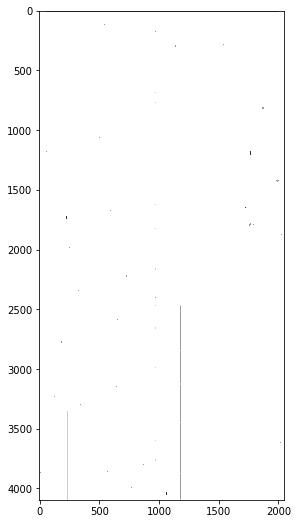

In [11]:
response = requests.get(fileurl)
if response.status_code == 200:
    print(f'HTTP-Status={response.status_code} File-size={len(response.content):,}')    
    zimage = pyfits.getdata(autils.data.download_file(fileurl,cache=True,show_progress=False,timeout=120))
    plt.rcParams["figure.figsize"] = [16,9]
    plt.imshow(zimage,cmap=matplotlib.cm.gray_r)
    zimage.shape
else:
    print(f'content={response.content}')
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use


### Get Core HDU field names and types <a id="core_hdu" />
These occur once per non-primary HDU and are optimized for fast search.

In [12]:
pd.read_json(json.dumps(requests.get(f'{adsurl}/core_hdu_fields').json())).transpose()

,0,1,2
boundary,str,val_string,Search a string field. Search spec is of form...
dec,np.float64,val_string,Search a string field. Search spec is of form...
dec_range,str,val_string,Search a string field. Search spec is of form...
fitsfile,str,val_string,Search a string field. Search spec is of form...
fitsfile__archive_filename,str,val_string,Search a string field. Search spec is of form...
fitsfile__caldat,str,val_string,Search a string field. Search spec is of form...
fitsfile__date_obs_max,str,val_string,Search a string field. Search spec is of form...
fitsfile__date_obs_min,str,val_string,Search a string field. Search spec is of form...
fitsfile__dec_max,str,val_string,Search a string field. Search spec is of form...
fitsfile__dec_min,str,val_string,Search a string field. Search spec is of form...


### Get Aux HDU field names and types <a id="aux_hdu" />
These occur once per non-primary HDU but will be slower to search.  All keywords from the non-primary HDUs (except those in Core HDU Fields) are included.

In [13]:
requests.get(f'{adsurl}/aux_hdu_fields/decam/raw/').json()

{'AMPSECA': 'str',
 'AMPSECB': 'str',
 'ASTIG1': 'str',
 'BIASSECA': 'str',
 'BIASSECB': 'str',
 'BSCALE': 'str',
 'BUNIT': 'str',
 'BZERO': 'str',
 'CCDBIN1': 'str',
 'CCDBIN2': 'str',
 'CCDNUM': 'str',
 'CCDSEC': 'str',
 'CCDSECA': 'str',
 'CCDSECB': 'str',
 'CD1_1': 'str',
 'CD1_2': 'str',
 'CD2_1': 'str',
 'CD2_2': 'str',
 'CHECKVER': 'str',
 'CRPIX1': 'str',
 'CRPIX2': 'str',
 'CRVAL1': 'str',
 'CRVAL2': 'str',
 'CTYPE1': 'str',
 'CTYPE2': 'str',
 'CUNIT1': 'str',
 'CUNIT2': 'str',
 'DARKTIME': 'str',
 'DATASEC': 'str',
 'DATASECA': 'str',
 'DATASECB': 'str',
 'DATE-OBS': 'datetime64',
 'DETECTOR': 'str',
 'DETPOS': 'str',
 'DETSEC': 'str',
 'DETSECA': 'str',
 'DETSECB': 'str',
 'DETSIZE': 'str',
 'DHEFIRM': 'str',
 'DHEINF': 'str',
 'DONUT10E': 'str',
 'DONUT10Z': 'str',
 'DONUT11E': 'str',
 'DONUT11Z': 'str',
 'DONUT12E': 'str',
 'DONUT12Z': 'str',
 'DONUT13E': 'str',
 'DONUT13Z': 'str',
 'DONUT14E': 'str',
 'DONUT14Z': 'str',
 'DONUT15E': 'str',
 'DONUT15Z': 'str',
 'DONUT16E':

## Advanced HDU Search of Core and Aux fields, results into Pandas <a id="hdu_search" />  

In [14]:
jj = {
    "outfields" : [
        "fitsfile__archive_filename",
        "fitsfile__caldat",
        "fitsfile__instrument",
        "fitsfile__proc_type",
        "ra",
        "dec",
    ],
    "search" : [
        ["fitsfile__instrument", "decam"],
        ["fitsfile__proc_type", "resampled"],
    ]
}
df = None # Pandas DataFrame
apiurl=f'{adsurl}/hasearch/?limit=9'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    df = pd.read_json(json.dumps(response.json()))
else:
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use
df

,dec,fitsfile__archive_filename,fitsfile__caldat,fitsfile__instrument,fitsfile__proc_type,ra
0,-52.52002,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,349.6496
1,-52.68315,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,349.9071
2,-52.51865,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,348.6289
3,-53.17259,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,350.4327
4,-53.33424,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,350.6966
5,-53.49877,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,350.7018
6,-53.66600,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,350.4457
7,-53.83016,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,350.4500
8,-53.99690,/net/archive/pipeline/Q20150727/DEC15A/2015072...,2015-07-23,decam,resampled,350.1903


## Error Conditions <a id="errors" />

### Examples of bad search specification
#### Attempt to search unknown field name

In [15]:
jj={
    "outfields" : [
        "ifilter",
        "archive_filename"
    ],
    "search" : [
        ["snafu","wubba"], # unknown field "snafu"
        ["instrument", "decam"]
    ]
}
df = None # Pandas DataFrame
apiurl=f'{adsurl}/fasearch/?limit=9'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    df = pd.read_json(json.dumps(response.json()))
else:
    print(response.json()['errorMessage'])
    #print(response.json()['traceback'])  # for API developer use
df

No "proc_type" was provided when searching for AUX fields. For performance reasons you must also filter on "instrument" and "proc_type" that contain the AUX fields you are searching on (snafu).


#### Attempt to retrieve field name not in known list

In [16]:
jj={
    "outfields" : [
        "baz",  # unknown field
        "foo",  # unknown field
        "ifilter",
        "archive_filename"
    ],
    "search" : [
        ["ifilter", "GG395 kGG395"],
    ]
}
df = None # Pandas DataFrame
apiurl=f'{adsurl}/fasearch/?limit=9'
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    df = pd.read_json(json.dumps(response.json()))
else:
    print(response.json()['errorMessage'])
    #print(response.json()['traceback'])  # for API developer use
df



These OUTFIELDS fields are not known to exist in any loaded headers (baz, foo). Available fields are: 051374_0, 051379_0, 051537_0, 051543_0, 051549_0, 051555_0, 051561_0, 051565_0, 051573_0, 051773_0, 051829_0, 051831_0, AAPROPID, ABSEC11, ABSEC12, ABSEC21, ABSEC22, ACQCNTRL, ACQDIGAV, ACQMODE, ACQPRIOR, ACQSEL0, ACQSEL1, ACQSEL10, ACQSEL11, ACQSEL12, ACQSEL13, ACQSEL14, ACQSEL15, ACQSEL2, ACQSEL3, ACQSEL4, ACQSEL5, ACQSEL6, ACQSEL7, ACQSEL8, ACQSEL9, ACQSTAT, ADC, ADCIN, ADCINNER, ADCNAME, ADCOUT, ADCOUTER, ADCPAN1, ADCPAN2, ADCPOS, ADCSTAT, ADCTRACK, ADC_CONF, ADC_MUX, ADC_OFSB, ADC_OFSG, ADC_OFSR, ADC_PGAB, ADC_PGAG, ADC_PGAR, ADC_ZERO, ADDAST, ADSEC11, ADSEC12, ADSEC21, ADSEC22, AIRMASS, ALT, ALTITIDE, ALTITUDE, AMBTEMP, AMP-CFG, AMP-PIX1, AMP-PIX2, AMPFLAT, AMPID, AMPINTEG, AMPLIST, AMPMERGE, AMPNAME, AMPNUM, AMPSEC, AMPSECA, AMPSECB, ANG-RES, AOS, APDHV, APDTIME, APER0001, APNUM1, AP_0_1, AP_0_2, AP_0_3, AP_1_0, AP_1_1, AP_1_2, AP_2_0, AP_2_1, AP_3_0, AP_ORDER, ARAWGAIN, ARCFILE

In [17]:
import datetime
elapsed = toc()  # Seconds since start of Notebook load (assuming fresh run)
print(f'Elapsed seconds={elapsed} on {natroot}')
print(f'Completed on: {str(datetime.datetime.now())}')

Elapsed seconds=52.76539162895642 on https://astroarchive1.dm.noao.edu
Completed on: 2020-01-30 15:54:14.505939


# Resources and references <a id="doc" />
- [automically generated API sepecifications](https://astroarchive.noao.edu/api/docs/#/api)
The package that generated this has been deprecated.  We will changed to something else which will like cause the format to change quite a bit.

- [NOAO Data Handbook](http://ast.noao.edu/sites/default/files/NOAO_DHB_v2.2.pdf) version 2.2, May 2015

# Glossary <a id="glos">
    
Term     | Definition
:---------| :---------------------------------------------------------------------------------------------
ProcType | Processing Type; pipeline process used to generate reduced FITS from raw FITS  
         | Possible types are raw, instcal, resampled, skysub, stack, mastercal
raw      | Raw data as obtained at the telescope
instcal  | Calibrated, single-frame reduced image with instrument signature removed, 
         | WCS and rough photometric calibrations applied
resampled | Calibrated, reprojected image
skysub   | Instcal image with sky pattern removed    
stack    | Stack of 2 or more overlapping images
mastercal | Calibration image
ProdType | Product Type; type of data product generated by the pipeline process
         | Possible types are image, dqmask, expmap, wtmap
image    | Image data product, contains the collected photons
dqmask   | Data quality mask, values can depend on pipeline processing versions, refer to documentation for details
expmap   | For image stacks, shows map of exposure time
wtmap    | Weight map, contains inverse variance of pixels
md5sum   | 128-bit MD5 hash, unique to each file in the archive